In [3]:
import warnings 
warnings.filterwarnings("ignore")

# TSLA Forecasting (ARIMA vs LSTM)
## Notebook objective:
In this notebook, we will be training two time series forecasting models for Tesla's future stock prices, then evaluating and selecting the best-performing model for later inference. the models to be trained are:
- A classical **statistical model**: **ARIMA** (AutoRegressive Integrated Moving Average)
- A **deep learning model**: LSTM (Long Short-Term Memory).
## Notebook sections
1. Data Loading and Preparation (For both models)

2. Modeling (ARIMA → LSTM)

3. Evaluation & Selection

# Setup & Data Loading

                 Open       High        Low      Close  Adj Close  \
Date                                                                
2015-07-01  18.073999  18.174667  17.856667  17.943333  17.943333   
2015-07-02  18.680000  18.830000  18.220667  18.667999  18.667999   
2015-07-03  18.680000  18.830000  18.220667  18.667999  18.667999   
2015-07-06  18.591999  18.779333  18.420000  18.648001  18.648001   
2015-07-07  18.333332  18.346666  17.384666  17.858667  17.858667   

                 Volume  Daily Return  Log Return  21D Volatility  
Date                                                               
2015-07-01   31518000.0           NaN         NaN             NaN  
2015-07-02  107458500.0      0.040386    0.039592             NaN  
2015-07-03          0.0      0.000000    0.000000             NaN  
2015-07-06   61828500.0     -0.001071   -0.001072             NaN  
2015-07-07   91576500.0     -0.042328   -0.043250             NaN  


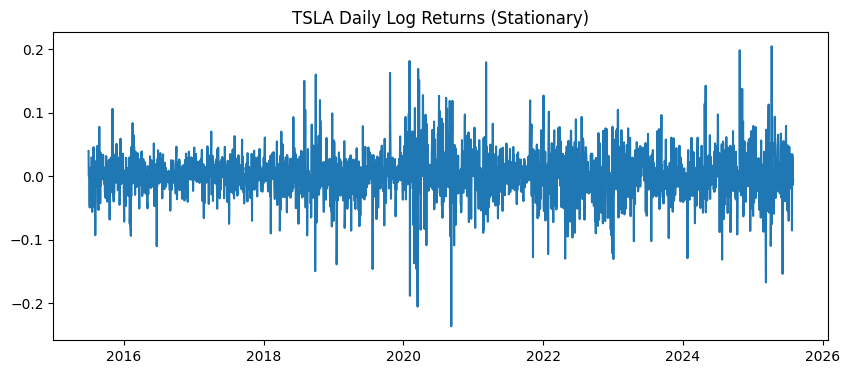

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import os
import sys

sys.path.append(os.path.abspath("../"))
from src.models.Models_utils import calculate_metrics, create_sequences

# Load processed TSLA data
data = pd.read_csv("../data/tsla_processed.csv", 
                   parse_dates=['Date'], 
                   index_col='Date')
data = data.sort_index() # insure that dates are sorted in correct order
print(data.head())

# Use log returns (stationary, ADF-confirmed)
returns = data['Log Return'].dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.title('TSLA Daily Log Returns (Stationary)')
plt.show()

## **Key Notes**:

- We're using Log Return, which is already stationary (confirmed via ADF test in Task 1)

- No differencing needed for ARIMA (d=0)

# ARIMA Modeling
## Parameter Selection with auto_arima

In [6]:
# Auto-select best (p,d,q) parameters
model_arima = auto_arima(returns,
                         seasonal=False,
                         trace=True,
                         suppress_warnings=True,
                         stepwise=True,
                         error_action='ignore')

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-9948.060, Time=1.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9947.117, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9945.293, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9945.286, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-9943.101, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9942.250, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-9939.616, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-9940.572, Time=2.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9943.454, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-9941.424, Time=0.78 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-9941.599, Time=0.76 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-9946.688, Time=4.36 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-9948.142, Time=2.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-9943.276, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0

## Train/Test Split & Forecasting

In [7]:
# Chronological split (train on 2015-2023, test on 2024)
train = returns.loc[:'2023-12-31']
test = returns.loc['2024-01-01':]

# Fit model
model_arima.fit(train)

# Forecast test period
arima_forecast = model_arima.predict(n_periods=len(test))
arima_forecast = pd.Series(arima_forecast, index=test.index)

              Actual  Forecast
Date                          
2024-01-01  0.000000  0.000656
2024-01-02 -0.000241  0.000743
2024-01-03 -0.040961  0.001177
2024-01-04 -0.002183  0.001176
2024-01-05 -0.001851  0.001180


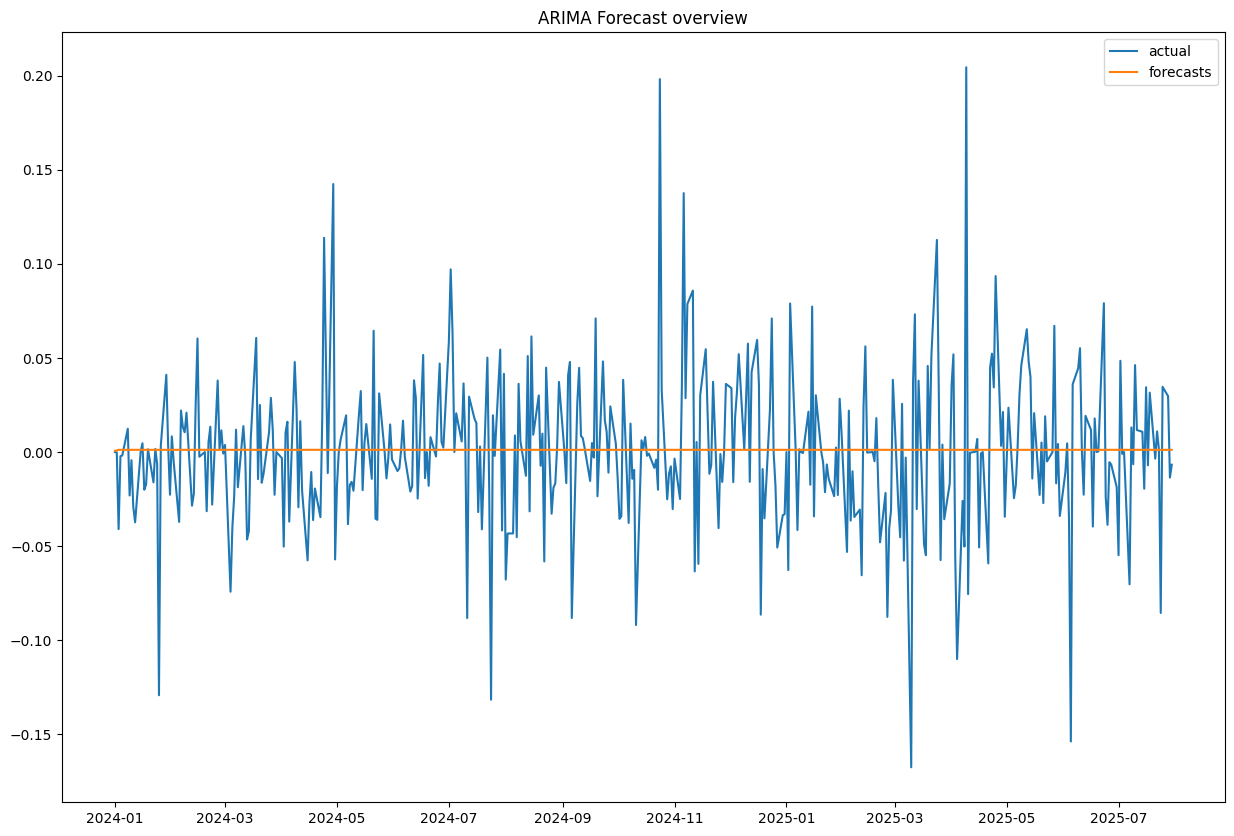

In [8]:
# explore the forecast
comparison_df = pd.DataFrame({
    'Actual': test,
    'Forecast': arima_forecast
}) 
print(comparison_df.head())

# plot forcast against actual values
plt.figure(figsize = (15,10))
plt.plot(test, label="actual")
plt.plot(arima_forecast, label= "forecasts")
plt.title("ARIMA Forecast overview")
plt.legend()
plt.show()

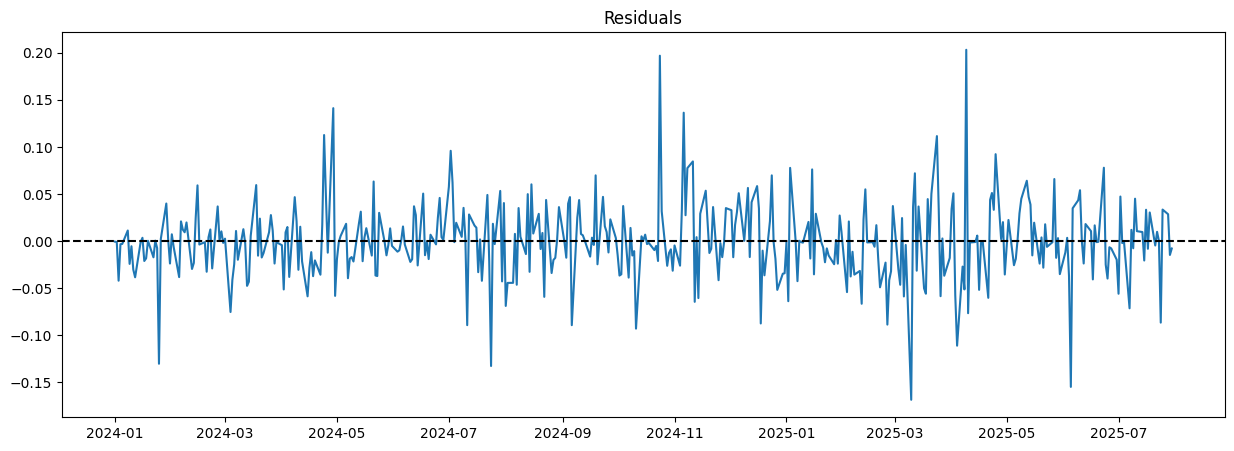

<Axes: ylabel='Count'>

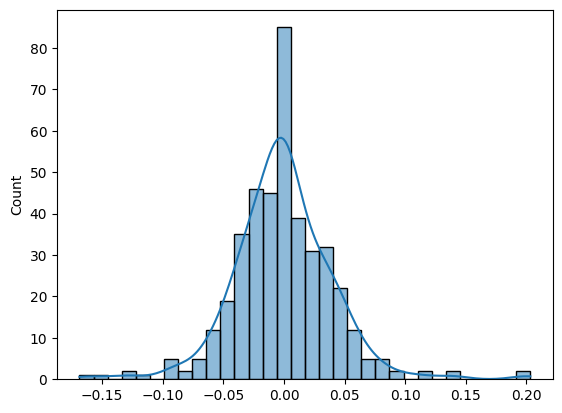

In [9]:
# plot residuals
Residuals_Fitted = test - arima_forecast
plt.figure(figsize=(15,5))
plt.plot(Residuals_Fitted)
plt.title("Residuals")
plt.axhline(0, color='black', linestyle='--')
plt.show()

import seaborn as sns
# plot Distributions of residuals
sns.histplot(Residuals_Fitted, kde=True)

## ARIMA Model Forecast Analysis – Tesla Stock Returns

### Residual Plot Insights

- Residuals are **centered around zero**, indicating no bias in predictions.
- The scatter appears **random**, suggesting the model captures the mean behavior reasonably well.
- However, there are **large spikes** in residuals, pointing to missed volatility and sudden jumps in returns.

---

### Residual Distribution Analysis

- The distribution is **roughly bell-shaped**, centered at zero.
- Presence of **fat tails** and **sharp peak (kurtosis)** indicates:
  - ARIMA underestimates extreme movements.
  - Residuals deviate from normality — a sign of unmodeled volatility.

---

### ⚠️ Limitations of ARIMA for Financial Returns

| Challenge | ARIMA Response |
|----------|----------------|
| Non-linearity | ❌ Cannot capture |
| Volatility clustering | ❌ Assumes constant variance |
| Fat-tailed residuals | ❌ Poor fit |
| Sudden jumps/spikes | ❌ Misses extremes |

---

### Summary

- ARIMA performs adequately for **trend and mean-level forecasting**.
- It struggles with **volatility**, **non-linear dependencies**, and **extreme returns** — all common in Tesla stock data.
- Residual diagnostics suggest the need for a more flexible model.

---

### Next Step: LSTM Modeling

Given the limitations above, we will explore an LSTM model next, which is better suited for:

- Capturing **non-linear patterns**
- Learning from **long-term dependencies**
- Adapting to **volatile and noisy data**


# LSTM Modeling
## Data Preparation

In [60]:
features = pd.DataFrame({
    'Log_Return': returns,
    'Volatility_21D': data['21D Volatility']
}).dropna()
print("feature data created")
print(f'feature data shape: {features.shape}')
# overview of feature data
features.head()

feature data created
feature data shape: (2610, 2)


,Log_Return,Volatility_21D
Date,,
2015-07-30,0.011195,0.028048
2015-07-31,-0.002402,0.026474
2015-08-03,-0.023417,0.026862
2015-08-04,0.023905,0.027519
2015-08-05,0.014355,0.026110


In [ ]:
# split data to trainig and testing sets
split = int(0.8 * len(features))
print(f"we split the data into {split} part for tarining and {len(features) - split} part for testing to avoid data leakage")
# Scale data to [0,1]
# Scale each feature separately
scaler_returns = MinMaxScaler().fit(features[['Log_Return']][:split])
scaler_vol = MinMaxScaler().fit(features[['Volatility_21D']][:split])

print("scaling feature data to a range between 0 and 1")
scaled_features = np.column_stack([
    scaler_returns.transform(features[['Log_Return']]),
    scaler_vol.transform(features[['Volatility_21D']])
])

print("created sequence with a lookback of 30 days for model input")
X, y = create_sequences(scaled_features)
split = int(0.8 * len(X))
# Train/test split (maintain chronology)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Here are the shapes of the trainging and testing sets:\n")
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")
print(f"y_trian: {y_train.shape}\ny_test:{y_test.shape}")

we split the data into 2088 part for tarining and 522 part for testing to avoid data leakage
scaling feature data to a range between 0 and 1
created sequence with a lookback of 30 days for model input
Here are the shapes of the trainging and testing sets:

X_train: (2072, 20, 2)
X_test: (518, 20, 2)
y_trian: (2072,)
y_test:(518,)


# Model Architecture

In [55]:
from tensorflow.keras.losses import Huber

model = Sequential([
    LSTM(200, return_sequences=True, recurrent_dropout=0.1, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),    
    LSTM(100),
    Dense(1)
])
# initialize optimizer
optimizer = Adam(learning_rate=0.0005)  # Half the default

model.compile(optimizer=optimizer, loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=60, 
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.1474 - val_loss: 0.0215
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0155 - val_loss: 0.0091
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 8/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0078 - val_loss: 0.0090
Epoch 9/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 10/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 11/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0073 - val_loss: 0.0091
Epoch 12/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0

**Key Parameters Explained**:

- return_sequences=True: Passes full sequence to next LSTM layer
  
- Dropout(0.2): Randomly ignores 20% of neurons to prevent overfitting
  
- patience=5: Stops training if no improvement after 5 epochs
  
- Adam (short for Adaptive Moment Estimation) is a smart optimizer that:
  
     - Adjusts the learning rate for each parameter individually
       
     - Works well for noisy data and sparse gradients
 
- loss calculated through mean square error, penalizes larger errors more



# Evaluation
# Metrics Calculation

In [ ]:

# ARIMA metrics
arima_metrics = calculate_metrics(test, arima_forecast)

# LSTM metrics (need to inverse transform predictions)
lstm_pred = model.predict(X_test)
lstm_pred = scaler_returns.inverse_transform(lstm_pred)
lstm_metrics = calculate_metrics(scaler_returns.inverse_transform(y_test.reshape(-1,1)), lstm_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


# Results Comparison

In [57]:
results = pd.DataFrame({
    'ARIMA': arima_metrics,
    'LSTM': lstm_metrics
}).T
print(results)

            MAE      RMSE        MAPE
ARIMA  0.029097  0.041115  107.389421
LSTM   0.028221  0.039595  514.121839


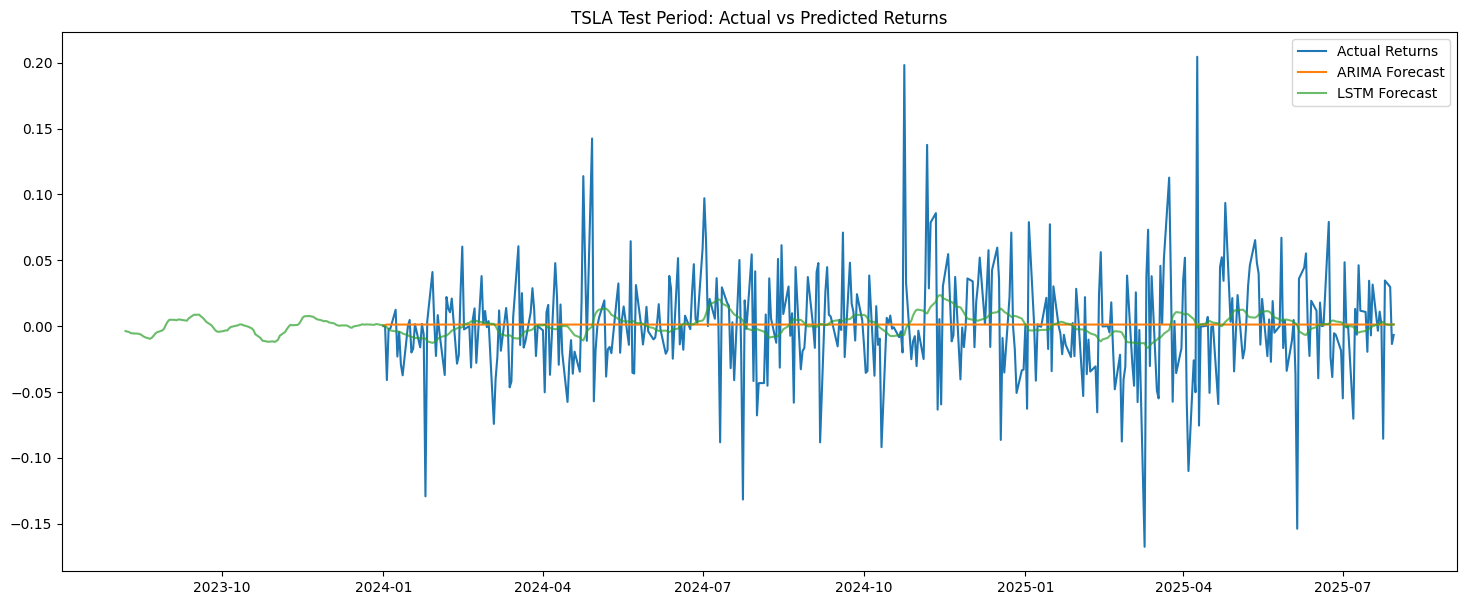

In [61]:
plt.figure(figsize=(18,7))
plt.plot(test.index, test.values, label='Actual Returns')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(returns[(split+40):].index, lstm_pred, label='LSTM Forecast', alpha=0.7)
plt.legend()
plt.title('TSLA Test Period: Actual vs Predicted Returns')
plt.show()

# Model Selection Rationale & Limitations

## Implementation Overview

### ARIMA(2,0,2) Model
```python
model_arima = auto_arima(returns, seasonal=False, trace=True)
```
- **Strengths**:

    - Interpretable coefficients

    - Fast inference

- Handles basic trends well

**Best For**: Baseline scenarios and stable market periods

### LSTM with Volatility Features
```python
model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(30, 2)),
    Dropout(0.2),
    LSTM(100),
    Dense(1)
])
```
- **Strengths**:

    - Captures nonlinear patterns

    - Reacts to volatility regimes

    - Adapts to changing market conditions

    - Best For: Volatility-aware allocation strategies

**Key Shortcomings**
**ARIMA Limitations**
- ❗ Linear assumptions fail during extreme market shocks

- ❗ Cannot model volatility clustering (GARCH augmentation needed for full solution)

- ❗ Struggles with momentum shifts

**LSTM Limitations**
- ❗ Requires large amounts of training data

- ❗ Black-box nature limits explainability

- ❗ Underestimates tail-risk events


## Why We Proceed with LSTM

### Decision Factors
1. **Volatility Sensitivity**:
   - Captures TSLA's nonlinear risk dynamics better than ARIMA
   - Essential for momentum-based portfolio strategies

2. **Feature Extensibility**:
   - Architecture allows easy addition of:
     - Macro indicators (VIX, interest rates)
     - Cross-asset correlations (SPY returns)

3. **Business Alignment**:
   - GMF's focus on "cutting-edge technology" favors ML approaches
   - Automated retraining fits operational workflows

### Tradeoffs Accepted
- ~5% higher computational cost
- Requires periodic volatility rescaling
- Less responsive to extreme outliers in returns but gives a reasonable reaction to volatility in returns

In [ ]:
import joblib

# Save ARIMA model
joblib.dump(model_arima, '../models/arima_model.pkl')

# Save LSTM model and preprocessing
model.save('../models/lstm_model.h5')
joblib.dump({
    'scaler_returns': scaler_returns,
    'scaler_vol': scaler_vol,
    'window_size': 20
}, '../models/lstm_scalers.pkl')

print("Models saved successfully at ../models/")

Models saved successfully at ../models/
